In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gmplot
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset
%matplotlib inline

# Access Points (APs) Power Levels

- Problem details

The broadcast signal power at a transmitting AP should be constrained by the receive signal power at all neighboring APs. If an AP receives signals from other APs above some noise threshold (-90 dBm in our case), these signals will interfere with the AP's ability to transmit and receive data from mobile hosts. The solution we are trying to find is that given a list of APs and their locations, what is the maximum signal broadcast strength for each AP such that their combined signals, when received by all nearby APs, is less than -90 dBm.

- Data source

The geographic locations of each AP comes from using a [Google Geolocation API](https://developers.google.com/maps/documentation/geolocation/overview) and inputting the MAC addresses of known UW Campus APs. Though the utility was meant to approximate signal receiver location, we can find the approximate location of the signal transmitter by placing the receiver in a location that receives the max possible signal strength from the transmitter.

- Physical model

The equation for the free space path loss detected at each receiver, $r$, from each transmitter, $t$, is 

$$P_r = \frac{\lambda^2P_tG_tG_r}{(4\pi)^2d^2}$$

Where $P$ is power, $G$ is gain, $\lambda$ is wavelength, $d$ is distance the signal travels between APs. We assume that the max power is -30 dBm as is conventional and that we are using IEEE 802.11ax but only using the 2.4 GHz band with no gain from either the transmitters or receivers.

- Assumptions

A lot of assumptions must be made to claim that this model will provide a good solution. First, the current model is only considering 2D distance as we do not have 3D information to consider APs on buildings with multiple floors. The free space path loss equation also does not take "shadowing" or the effects of obstructions on signal strength into account.

Basic assumptions are also made about the noise threshold and its benefits to wireless communications in that we assume if APs cannot interfere with each other, then the canonical "exposed terminal" problem is avoided. This would leave the "hidden terminal" problem for communicating with mobile hosts in the signal range of multiple APs. We mitigate this by assuming that mobile hosts always connect to the AP with the strongest signal strength at their location and that this signal is sufficiently strong to produce the "capture effect" that blocks out all other interfering signals. If the client device is at a location such that signal power between APs is equal, we assume Multiple Access Collision Avoidance (MACA) protocols will avoid the "hidden terminal" problem for the mobile host.

Illustration of the hidden and exposed terminal problems. X and Z are the transmitting terminals and Y is the host in the "hidden terminal" case and Y and Z are the transmitting terminals and X and K are the mobile hosts in the "exposed terminal" case
![Hidden and Exposed Terminals](./wireless_comm.png)

- Optimization Approach

Even though the signal strength at any location is proportional to the square distance away from the transmitting AP, all of the mathematical quantities can be computed prior to the optimization iterations using the provided data. This allows us to formulate the problem as a Linear Programming problem, which should guarantee a global optimal solution.

In [2]:
%%gams
option limcol=0, limrow=0;
option decimals=8;

set A 'set of attributes' /'latitude', 'longitude'/;
set N 'set of APs' /ap1*ap13/;

Table coord(A,N) 'table of decimal degree coordinates to work from'
$ONDELIM
$INCLUDE data1.csv
$OFFDELIM
;

alias(M,N);

parameter arcs(N,N);
arcs(M,N)$(ord(M) ne ord(N)) = yes;


* Haversine formula to convert to euclidean distance
scalar
  E_rad 'radius of Earth in km' /6373/;

parameters
  dlat(M,N) 'distance in latitude values for AP pairs in radians',
  dlong(M,N) 'distance in longitude values for AP pairs in radians',
  angle(M,N) 'squared angular distance of the decimal degrees',
  euc_dist(M,N) 'euclidean distance in meters';

dlat(M,N)$arcs(M,N) = pi/180 * (coord('latitude',N) - coord('latitude',M));
dlong(M,N)$arcs(M,N) = pi/180 * (coord('longitude',N) - coord('longitude',M));
angle(M,N)$arcs(M,N) = power(sin(dlat(M,N)/2), 2)+
                        cos(coord('latitude',M))*
                        cos(coord('latitude',N))*
                        power(sin(dlong(M,N)/2), 2);
euc_dist(M,N)$arcs(M,N) = E_rad * 2 * arctan2( sqrt(angle(M,N)), sqrt(1-angle(M,N))) * 1000;


free variables
  signal_strength;
  
positive variables
  x(M) 'power to set for AP M in mW',
  y(M,N) 'power received at AP N from AP M in mW';
  
scalar
  noise_thresh 'power under which signal will be treated as noise in mW' /1e-9/,
  wavelen 'wavelength of signal waves in m' /0.125/;
  
equations
  obj,
  pathloss(M,N),
  noise(N);

obj..
  signal_strength =e= sum((M,N)$arcs(M,N), y(M,N));
  
pathloss(M,N)$arcs(M,N)..
  y(M,N) =e= x(M) * power(wavelen,2) / (power((4*pi),2) * power(euc_dist(M,N),2));
  
noise(N)..
  sum(M, y(M,N))*1e9 =l= noise_thresh *1e9; 

x.up(M) = 1e-3;
x.lo(M) = 1e-9;
  
model main /all/;
solve main using lp maximizing signal_strength;

parameter upbound(M,N);
upbound(M,N) = noise_thresh * power((4*pi),2) * power(euc_dist(M,N),2) / power(wavelen,2);

parameter signal_dBm(M);
signal_dBm(M) = 10*log10(x.l(M));

option signal_dBm:1:0:1;
display signal_dBm;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.0,170,183,LP,CPLEX,0.025


In [3]:
%gams_pull -d signal_dBm

## Visualization

In [4]:
location = pd.read_csv('data1.csv', index_col=0)
df = pd.DataFrame(data={'API': signal_dBm['N'], 'signal': signal_dBm['value'],\
                        'latitude': location.loc['latitude', :].values,\
                        'longitude': location.loc['longitude', :].values})

In [5]:
BBox = (df.longitude.min() - 0.00005, df.longitude.max() + 0.00005,      
        df.latitude.min() - 0.00005, df.latitude.max() + 0.00005)

### Scatter plot

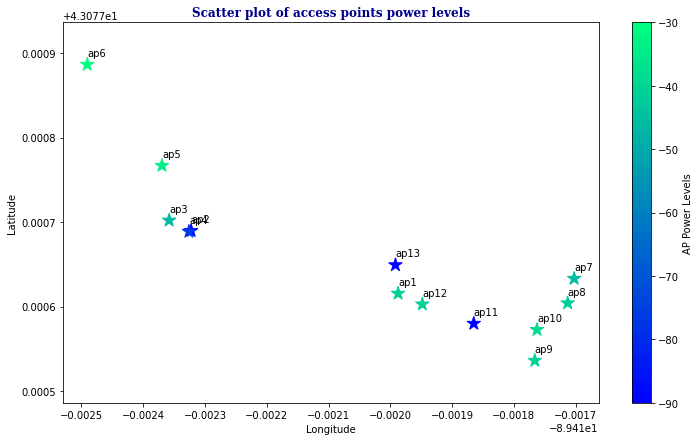

In [6]:
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 7)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Scatter plot of access points power levels',\
             fontdict={'family': 'serif', 
                       'color' : 'darkblue',
                       'weight': 'bold',
                       'size': 12})
plt.scatter(df.longitude, df.latitude, c=df.signal, cmap = 'winter', marker='*', s=200)
for i in range(13):
    ax1.text(df.longitude[i], df.latitude[i] + 0.00001, str(df.API[i]))
plt.ylim((BBox[2], BBox[3]))
cbar = plt.colorbar()
cbar.set_label('AP Power Levels')
plt.savefig('scatter_plot_signal.png')

### Plot on map

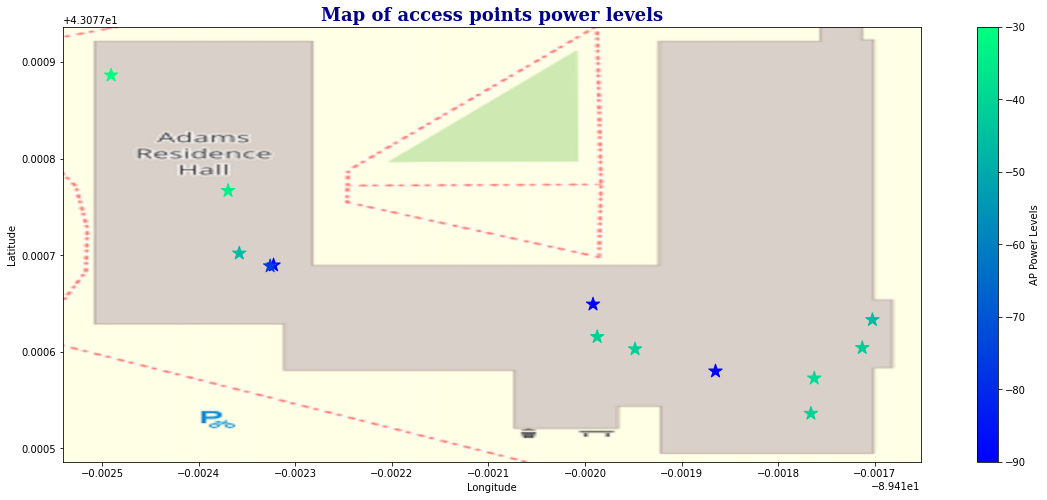

In [7]:
# AP locations are all from Adams Residence Hall
# Map from https://www.openstreetmap.org/

ruh_m = plt.imread('map_base.png')
fig, ax = plt.subplots(figsize = (20, 8))
plt.scatter(df.longitude, df.latitude, zorder=1, c = df.signal, 
            cmap = 'winter', marker='*', s=200)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Map of access points power levels',\
             fontdict={'family': 'serif', 
                       'color' : 'darkblue',
                       'weight': 'bold',
                       'size': 18})
cbar = plt.colorbar()
cbar.set_label('AP Power Levels')
plt.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('map_signal.png')